## PDE model of advection, diffusion and membrane exchange

Aiming to investigate the efffects of membrane diffusion and membrane-cytoplasm exchange on segregation efficiency. This notebook shows code for running single simulations with a specified D and koff.

### Instructions

To run all code and open interactive figures, click Cell > Run all. Specify core parameters for the simulations in the cell below. If these parameters are changed, go to Cell > Run All again to re-run the model with the new parameters. Other model parameters are outlined below. 

In [1]:
D = 0.1 ### <- diffusion coefficient on the membrane (µm^2/s)
koff = 0.005 ### <- membrane unbinding rate (/s)

### Import packages

In [2]:
from pdeRK import pdeRK
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib notebook

### Cortical flow profile

We will use the following cortical flow profile in a system 60 µm in length (anterior pole to posterior pole), which is based on measurements of nmy-2 velocity. Positive values reflect movement from the posterior to the anterior.

In [3]:
def generate_flow_profile(A=74, B=391, C=1000, D=100):
    X = np.linspace(0, 60, 100)
    v = (((60-X) / A) * np.exp(-((60-X) ** 2) / B)) - ((X / C) * np.exp(-(X ** 2) / D))
    return v

<IPython.core.display.Javascript object>


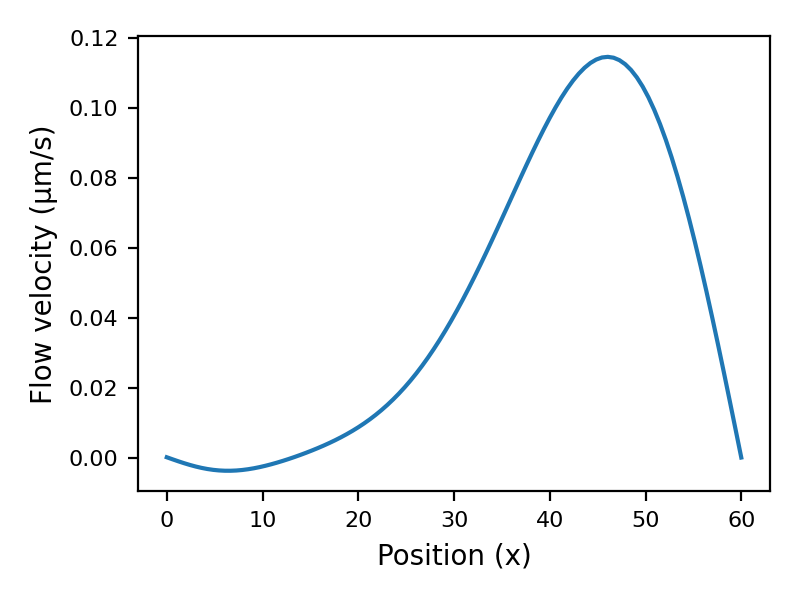

In [4]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0, 60, 100), generate_flow_profile())
ax.set_xlabel('Position (x)')
ax.set_ylabel('Flow velocity (µm/s)')
ax.tick_params(axis='both', labelsize=8)
fig.set_size_inches(4, 3)
fig.tight_layout()

### Building a PDE model

To build and solve a PDE model we will use the pdeRK function found in the the pdeRK.py file. This is a versatile PDE solver that can be used to solve any system of PDEs, using an adaptive Runge-Kutta method.

```python
soln, time, solns, times = pdeRK(dxdt, X0, Tmax, deltat, t_eval, killfunc=None, stabilitycheck=False, maxstep=None, rk=True)
```

The function takes the following inputs:
- dxdt: a function that takes list of 1D arrays (one for each species) corresponding to concentrations over space, and returns a list of gradient arrays
- X0: a list specifying the initial state of the system. Will be used as the input to dxdt on the first time step
- Tmax: timepoint at which to terminate simulation
- deltat: initial timestep (this will be adapted throughout the simulation)
- t_eval: a list of timepoints for which to save the state of the system
- killfunc: an optional kill function that takes the same input as dxdt. Integration will terminate when this function returns True
- stabilitycheck: if True, integration will terminate when the system stabilises (changes by less that 1% per 60 time units). Default is False
- maxstep: maximum time step to tolerate
- rk: if True, the function will use an adaptive Runge-Kutta method. If False, the function will use a basic Euler method with a constant time step

The function returns the following outputs:
- soln: final solution 
- time: final time. Will be close to Tmax but not exact due to finite and adaptable time step
- solns: solutions at times specified by t_eval
- times: times corresponding to saved states in solns. Will be close to times specified in t_eval but not exact due to finite and adaptable time step

The full PDE model is built as a Python class:

In [5]:
class Model:
    def __init__(self, D, kon, koff, psi=0.174, tot=1.56):

        # Diffusion
        self.D = D # diffusion coefficient

        # Flow profile
        self.flow_profile = generate_flow_profile()

        # Membrane exchange
        self.kon = kon # membrane binding rate
        self.koff = koff # membrane unbinding rate

        # Misc
        self.tot = tot # total amount of protein
        self.psi = psi # surface area to volume ratio
        self.xsteps = 100 # number of positions to split the spatial dimension into
        self.L = 60 # system length
        self.deltax = self.L / self.xsteps # spatial step

    def diffusion(self, concs, dx):
        concs_ = np.r_[concs[0], concs, concs[-1]] # Dirichlet boundary conditions
        d = concs_[:-2] - 2 * concs_[1:-1] + concs_[2:]
        return d / (dx ** 2)

    def flow(self, concs, dx):
        # Calculates the gradient in both directions and takes the average
        return (np.r_[0, np.diff(concs * self.flow_profile)] +
                  np.r_[np.diff(concs * self.flow_profile), 0]) / (2 * dx)

    def dxdt(self, X):
        m = X[0]
        c = self.tot - self.psi * np.mean(m) # calculate uniform cytoplasmic concentration
        flow = self.flow(m, self.deltax)
        dm = (self.kon * c) - (self.koff * m) + (self.D * self.diffusion(m, self.deltax)) + flow
        return [dm, ]

    def dxdt_no_flow(self, X):
        m = X[0]
        c = self.tot - self.psi * np.mean(m) # calculate uniform cytoplasmic concentration
        dm = (self.kon * c) - (self.koff * m) + (self.D * self.diffusion(m, self.deltax))
        return [dm, ]

    def run(self, Tmax, t_eval=None, start=None, flow=True, killfunc=None, maxstep=None, rk=True):

        # Specify evaluation times
        if t_eval is None:
            t_eval = np.arange(0, Tmax + 0.0001, Tmax)

        # Specify starting conditions
        if start is None:
            # Start from uniform equilibrium membrane concentration, calculated analytically
            start = (self.kon * self.tot) / (self.koff + self.psi * self.kon)
            start *= np.ones([self.xsteps])

        # Specify flow regime
        if flow:
            func = self.dxdt
        else:
            func = self.dxdt_no_flow

        # Run simulation
        soln, time, solns, times = pdeRK(dxdt=func, X0=[start, ], Tmax=Tmax, deltat=0.01, t_eval=t_eval, 
                                         killfunc=killfunc, maxstep=maxstep)
        # Return results
        return soln, time, solns, times

### Simulate segregation

Starting from a uniform equilibrium state, systems are simulated with the cortical flow profile shown above

In [6]:
# Build the class
m = Model(D=D, koff=koff, kon=koff)

# Specify simulation length (in seconds)
Tmax_seg = 500 

# Run simulation (flow=True)
soln_seg, time_seg, solns_seg, times_seg = m.run(Tmax=Tmax_seg, flow=True,
                                                 t_eval=np.arange(0, Tmax_seg + 1, 10))

#### Interactive figure to view simulation results

In [7]:
def interactive_fig(solns, times):
    fig, ax = plt.subplots()
    ymax = 1.1 * np.max(solns[0])
    @widgets.interact(Time=(0, times[-1], 10))
    def update(Time=0):
        ax.clear()
        tpoint = np.argmin(abs(times - Time))
        ax.plot(np.linspace(0, 60, 100), solns[0][tpoint])
        ax.set_ylim(0, ymax)
        ax.set_xlabel('Position (x)')
        ax.set_ylabel('Membrane concentration')
        ax.tick_params(axis='both', labelsize=8)

    fig.set_size_inches(4,3)
    fig.tight_layout()

<IPython.core.display.Javascript object>


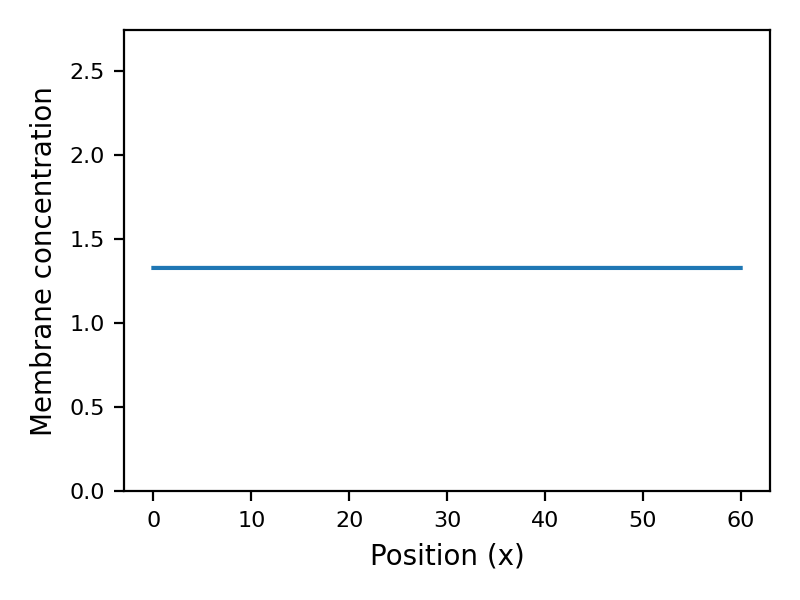

interactive(children=(FloatSlider(value=0.0, description='Time', max=500.0000000000452, step=10.0), Output()),…

In [8]:
interactive_fig(solns_seg, times_seg)

#### Score final asymmetry index (ASI)

In [9]:
def calc_asi(m):
    ant = np.mean(m[:30])
    post = np.mean(m[-30:])
    asi = abs((ant - post) / (2 * (ant + post)))
    return asi

In [10]:
asi_seg = calc_asi(soln_seg[0])
print('ASI = %.3f' % asi_seg)

ASI = 0.254


### Simulate relaxation

Starting from the final state of the above simulation, flows are switched off and the system is left to relax

In [11]:
# Specify simulation length (in seconds)
Tmax_rel = 1000 

# Run simulation (flow=False)
soln_rel, time_rel, solns_rel, times_rel = m.run(start=soln_seg[0], flow=False, Tmax=Tmax_rel,
                                                t_eval=np.arange(0, Tmax_rel + 1, 10))    

<IPython.core.display.Javascript object>


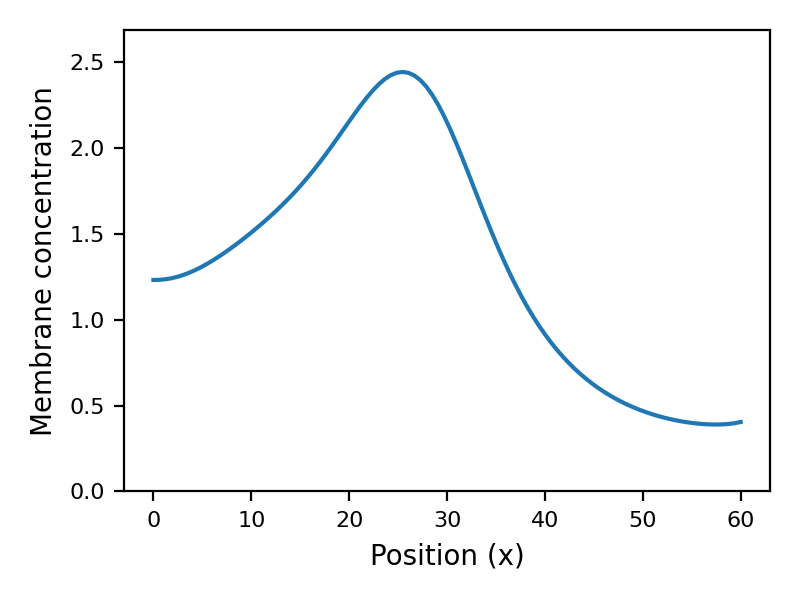

interactive(children=(FloatSlider(value=0.0, description='Time', max=1000.0000000001588, step=10.0), Output())…

In [12]:
# Plot simulation
interactive_fig(solns_rel, times_rel)

### Calculate timescale of relaxation

Calculating the time for ASI to decrease to half of its initial value. To do so we will use the killfunc option in the pdeRK function so simulate the system until ASI has decreased by half. We will also set maxstep=0.1 to limit the maximum time step so that times are calculated to the nearest 0.1 second.

In [13]:
# Set up kill function
def killfunc(X, asi_thresh=asi_seg * 0.5):
    current_asi = calc_asi(X[0])
    if current_asi < asi_thresh:
        return True
    return False

# Run simulation (flow=False)
_, relaxation_time, _, _  = m.run(Tmax=10000, start=soln_seg[0], flow=False, killfunc=killfunc, maxstep=0.1)

# Print relaxation time (seconds)
print('Relaxation time = %.1f seconds' % relaxation_time)

Relaxation time = 108.7 seconds
